In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
import h5py

In [14]:
def prepare_data(csv_path):
    # Read the CSV file
    df = pd.read_csv(csv_path)
    
    # Separate features and target
    X = df.drop(['LABEL', 'FILE_PATH'], axis=1)  # Remove label and file path columns
    y = df['LABEL']  # Target variable
    
    # Convert categorical labels to numeric values
    y = y.map({'FAKE': 0, 'REAL': 1}) 
    
    # Store feature names before scaling
    feature_names = X.columns.tolist()
    
    # Split the data
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names

In [15]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names):
    # Initialize models
    models = {
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
        'XGBoost': XGBClassifier(random_state=42),
        'SVM': SVC(kernel='rbf', random_state=42, probability=True)
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nTraining {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate and store metrics
        results[name] = {
            'classification_report': classification_report(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred)
        }
        
        # Print results
        print(f"\n{name} Results:")
        print("Classification Report:")
        print(results[name]['classification_report'])
        
        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(results[name]['confusion_matrix'], 
                   annot=True, 
                   fmt='d', 
                   cmap='Blues',
                   xticklabels=['Real', 'Fake'],
                   yticklabels=['Real', 'Fake'])
        plt.title(f'Confusion Matrix - {name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()
        
        # For Random Forest, show feature importance
        if name == 'Random Forest':
            feature_importance = pd.DataFrame({
                'feature': feature_names,
                'importance': model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            plt.figure(figsize=(10, 6))
            sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
            plt.title('Top 10 Most Important Features')
            plt.show()
    
    return models, results

In [16]:
def predict_single_audio(model, scaler, features, feature_names):
    """
    Make prediction for a single audio file's features
    """
    # Ensure features are in the correct order
    features_df = pd.DataFrame([features], columns=feature_names)
    
    # Scale the features
    features_scaled = scaler.transform(features_df)
    
    # Make prediction
    prediction = model.predict(features_scaled)
    probability = model.predict_proba(features_scaled)[0]
    
    return prediction[0], probability

In [17]:
def save_model_to_h5(model, scaler, feature_names, filepath="deepfake_model.h5"):
    """
    Save trained model and scaler to HDF5 file
    Args:
        model: Trained SVM model
        scaler: Fitted StandardScaler
        feature_names: List of feature names
        filepath: Path to save HDF5 file
    """
    with h5py.File(filepath, 'w') as hf:
        # Save SVM model parameters
        svm_group = hf.create_group('svm_model')
        svm_group.attrs['svm_type'] = 'rbf'
        svm_group.attrs['gamma'] = model.gamma
        svm_group.attrs['C'] = model.C
        svm_group.create_dataset('support_vectors', data=model.support_vectors_)
        svm_group.create_dataset('dual_coef', data=model.dual_coef_)
        svm_group.create_dataset('intercept', data=model.intercept_)
        svm_group.create_dataset('classes', data=model.classes_)
        
        # Save Scaler parameters
        scaler_group = hf.create_group('scaler')
        scaler_group.create_dataset('mean', data=scaler.mean_)
        scaler_group.create_dataset('scale', data=scaler.scale_)
        scaler_group.create_dataset('var', data=scaler.var_)
        scaler_group.attrs['feature_names'] = np.string_(feature_names)


Training Random Forest...

Random Forest Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      2324
           1       0.98      1.00      0.99      4045

    accuracy                           0.98      6369
   macro avg       0.99      0.98      0.98      6369
weighted avg       0.98      0.98      0.98      6369



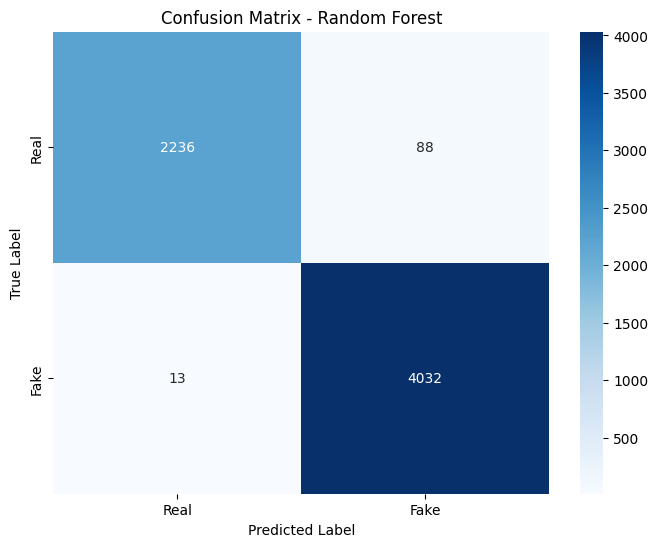

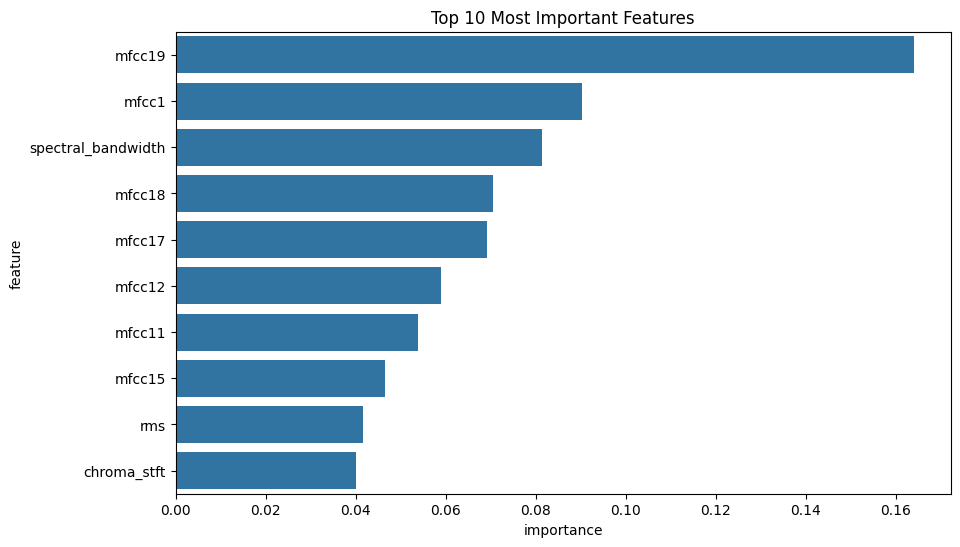


Training XGBoost...

XGBoost Results:
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2324
           1       0.99      1.00      0.99      4045

    accuracy                           0.99      6369
   macro avg       0.99      0.99      0.99      6369
weighted avg       0.99      0.99      0.99      6369



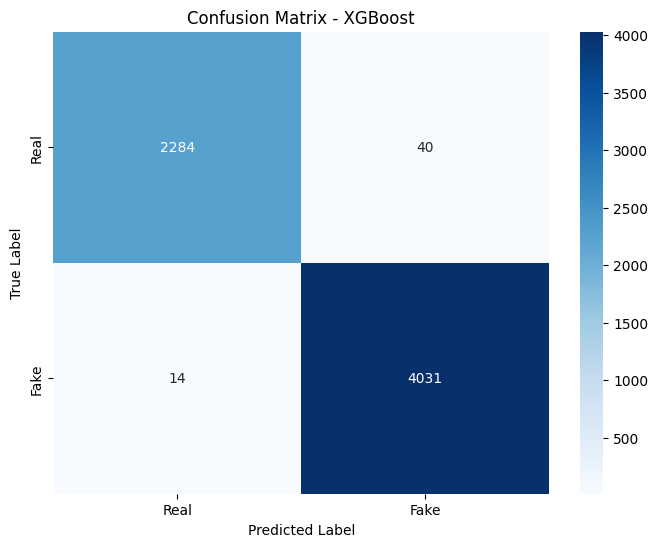


Training SVM...

SVM Results:
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      2324
           1       0.99      1.00      1.00      4045

    accuracy                           1.00      6369
   macro avg       1.00      0.99      1.00      6369
weighted avg       1.00      1.00      1.00      6369



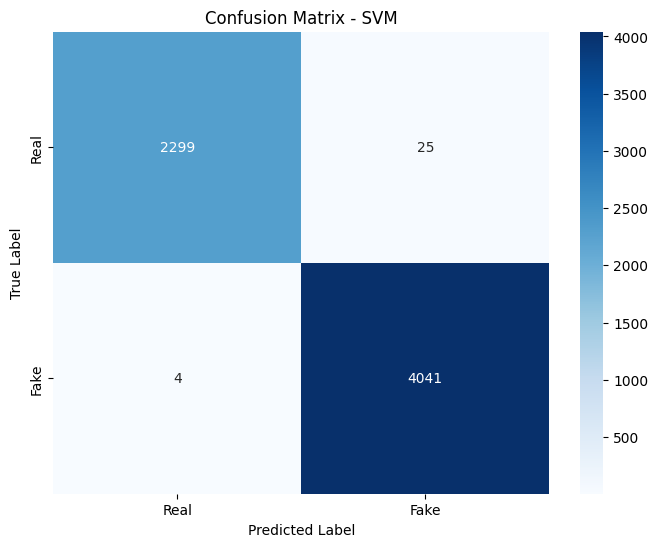

Saved SVM model and scaler to deepfake_detector.h5


In [18]:
if __name__ == "__main__":
    # Path to your CSV file
    csv_path = "dataset/csv/audio_features.csv"
    
    # Prepare the data
    X_train, X_test, y_train, y_test, feature_names = prepare_data(csv_path)
    
    # Train and evaluate models
    models, results = train_and_evaluate_models(X_train, X_test, y_train, y_test, feature_names)
    
    # Save the best model (SVM) to HDF5
    svm_model = models['SVM']
    scaler = StandardScaler().fit(X_train)  # Refit scaler on full training data
    
    save_model_to_h5(svm_model, scaler, feature_names, "deepfake_detector.h5")
    print("Saved SVM model and scaler to deepfake_detector.h5")